In [1]:
# ============================================================================
# 1. SETUP & CONFIGURATION
# ============================================================================

# --- Installations ---
# All packages are installed in a single, quiet command.
!pip install -q geopandas folium osmnx scikit-learn tensorflow plotly census requests contextily

# --- Core Libraries ---
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import warnings
import json

# --- Visualization ---
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import contextily as cx

# --- Machine Learning ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf

# --- Geospatial & API ---
from census import Census
from shapely.geometry import Point

# --- Configuration & Seeds ---
# This ensures that ML models and other random processes are reproducible.
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define your API key once here for easy access.
from google.colab import userdata
CENSUS_API_KEY = userdata.get('CENSUS_API_KEY')

# Suppress warnings for a cleaner final notebook.
warnings.filterwarnings('ignore')

# Set display options for libraries.
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

print("Setup complete! Libraries imported and environment configured.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 105.5 MB/s eta 0:00:00
Setup complete! Libraries imported and environment configured.


In [2]:
# --- 2. LOAD COMPETITOR DATA ---

# Define the file path for clarity
gdrive_path = "/content/drive/MyDrive/"
facilities_filepath = gdrive_path + "storage_poi_phoenix.geojson"

# Load the geojson file into a GeoDataFrame
facilities_gdf = gpd.read_file(facilities_filepath)

# --- Initial Data Inspection ---
print("--- Competitor Data Report ---")
print(f"Data loaded successfully from: {facilities_filepath}")
print(f"\nShape of the dataset (rows, columns): {facilities_gdf.shape}")
print(f"Coordinate Reference System (CRS): {facilities_gdf.crs}")

# Calculate and print the total number of missing values
total_missing = facilities_gdf.isnull().sum().sum()
print(f"Total missing values across all columns: {total_missing}")

# Display the first few rows for visual inspection
print("\n--- Data Preview ---")
display(facilities_gdf.head())

--- Competitor Data Report ---
Data loaded successfully from: /content/drive/MyDrive/storage_poi_phoenix.geojson

Shape of the dataset (rows, columns): (559, 72)
Coordinate Reference System (CRS): EPSG:4326
Total missing values across all columns: 33928

--- Data Preview ---


,id,@id,addr:city,addr:country,addr:housenumber,addr:inclusion,addr:postcode,addr:state,addr:street,addr:unit,air_conditioning,bicycle,branch,brand,brand:wikidata,building,building:levels,building:use,check_date,contact:phone,contact:website,country,currency:USD,description,entrance,fixme,foot,height,highway,industrial,internet_access,internet_access:fee,internet_access:ssid,landuse,layer,max_level,maxspeed,min_level,motor_vehicle,name,name:full,name:prefix,office,oneway,opening_hours,opening_hours:access,opening_hours:gate,opening_hours:office,opening_hours:url,operator,owner,payment:american_express,payment:amex,payment:cash,payment:cheque,payment:credit_cards,payment:debit_cards,payment:discover_card,payment:mastercard,payment:visa,phone,ref,roof:levels,roof:shape,shop,source,surface,type,website,wheelchair,@geometry,geometry
0,relation/14925721,relation/14925721,Mesa,None,8050,None,85207,AZ,East Main Street,None,None,None,None,None,None,yes,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,American Self Storage,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,storage_rental,microsoft/BuildingFootprints,None,multipolygon,None,None,center,POINT (-111.65715 33.41645)
1,relation/14926238,relation/14926238,Mesa,None,8847,None,85207,AZ,East Main Street,None,None,None,None,None,None,yes,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,202 RV Valet Storage,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,+14809127200,None,None,None,storage_rental,microsoft/BuildingFootprints,None,multipolygon,None,None,center,POINT (-111.64002 33.41311)
2,relation/14943562,relation/14943562,Mesa,None,1240,None,85207,AZ,North Ellsworth Road,None,None,None,None,None,None,yes,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,The Garages,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,storage_rental,None,None,multipolygon,None,None,center,POINT (-111.63349 33.43791)
3,relation/15097371,relation/15097371,Mesa,None,1661,None,85210,AZ,South Alma School Road,None,None,None,None,None,None,yes,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,US 60 Self Storage,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,storage_rental,None,None,multipolygon,None,None,center,POINT (-111.85577 33.38426)
4,way/34149484,way/34149484,Mesa,None,1750,None,85201,AZ,North Country Club Drive,None,None,None,None,US Storage Centers,Q126362860,None,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,US Storage Centers,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,storage_rental,esri/USA_NAD_Addresses;esri_USDOT_Arizona,None,None,None,None,center,POINT (-111.8409 33.44741)


In [3]:
# --- 3. LOAD GEOGRAPHIC BOUNDARIES (CENSUS TIGER/LINE) ---

from pathlib import Path
import zipfile

# --- File Paths ---
gdrive_path = Path("/content/drive/MyDrive/")
zip_filepath = gdrive_path / "tl_2020_04_bg.zip"  # Arizona Block Groups shapefile
extract_path = Path("/content/census_data/")

# --- Unzip the Shapefile ---
# Create the extraction directory if it doesn't exist.
extract_path.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# --- Find and Load the Shapefile ---
# Use rglob to efficiently find the .shp file within the extracted folder.
try:
    # Find the first file ending in .shp inside the directory
    shapefile_path = next(extract_path.rglob("*.shp"))

    # Load the shapefile into a GeoDataFrame
    census_gdf = gpd.read_file(shapefile_path)

    # --- Initial Data Inspection Report ---
    print("--- Geographic Boundaries Report ---")
    print(f"Successfully unzipped and loaded shapefile from: {shapefile_path}")
    print(f"\nShape of the dataset (rows, columns): {census_gdf.shape}")
    print(f"Coordinate Reference System (CRS): {census_gdf.crs}")
    print("\n--- Data Preview (State of Arizona) ---")
    display(census_gdf.head())

except StopIteration:
    print(f"ERROR: No .shp file was found in the directory: {extract_path}")

--- Geographic Boundaries Report ---
Successfully unzipped and loaded shapefile from: /content/census_data/tl_2020_04_bg.shp

Shape of the dataset (rows, columns): (4773, 13)
Coordinate Reference System (CRS): EPSG:4269

--- Data Preview (State of Arizona) ---


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,021,001709,1,040210017091,Block Group 1,G5030,S,2599103,0,+33.0805595,-112.0047277,"POLYGON ((-112.01312 33.08255, -112.01311 33.0..."
1,04,021,001709,2,040210017092,Block Group 2,G5030,S,2611665,0,+33.0658482,-112.0048844,"POLYGON ((-112.01346 33.05881, -112.01346 33.0..."
2,04,003,002002,2,040030020022,Block Group 2,G5030,S,18190933,1102,+31.4529670,-110.1945160,"POLYGON ((-110.22384 31.4397, -110.22383 31.44..."
3,04,003,002002,1,040030020021,Block Group 1,G5030,S,18439678,0,+31.4823022,-110.1949990,"POLYGON ((-110.22414 31.47988, -110.22364 31.4..."
4,04,003,001401,2,040030014012,Block Group 2,G5030,S,6338558,14981,+31.5638377,-110.3251603,"POLYGON ((-110.3414 31.55929, -110.34076 31.55..."


In [4]:
# --- ADDENDUM: LOADING CIVIC DATA (ZONING & TRAFFIC) ---

print("Loading new civic datasets...")

# --- 1. Define File Paths ---
# Replace these with the actual paths to the files in your Google Drive.
zoning_filepath = "/content/drive/MyDrive/Zoning.zip"
traffic_filepath = "/content/drive/MyDrive/Street_Traffic_Volumes.zip"

# --- 2. Load the Datasets ---
try:
    zoning_gdf = gpd.read_file(zoning_filepath)
    print("✅ Zoning data loaded successfully.")

    # --- Zoning Data Report ---
    print("\n--- Zoning Data Report ---")
    print(f"Shape: {zoning_gdf.shape}")
    print(f"CRS: {zoning_gdf.crs}")
    display(zoning_gdf.head())

except Exception as e:
    print(f"Could not load zoning data. Check the file path. Error: {e}")

try:
    traffic_gdf = gpd.read_file(traffic_filepath)
    print("\nTraffic data loaded successfully.")

    # --- Traffic Data Report ---
    print("\n--- Traffic Data Report ---")
    print(f"Shape: {traffic_gdf.shape}")
    print(f"CRS: {traffic_gdf.crs}")
    display(traffic_gdf.head())

except Exception as e:
    print(f"\nCould not load traffic data yet. Check the file path. Error: {e}")
    traffic_gdf = None

Loading new civic datasets...
✅ Zoning data loaded successfully.

--- Zoning Data Report ---
Shape: (9480, 22)
CRS: EPSG:2868


,OBJECTID,ACRES,ZPREFIX,ZCASE,ZREVISION,ZYEAR,SPPREFIX,SPCASE,SPREVISION,SPYEAR,ZONING,REDEFINE1,DATE_APPRO,LABEL1,ORD_NUM,HISTORIC,GEN_ZONE,INSERT_DAT,UPDATE_DAT,ANID,TOD,geometry
0,2954982,4.513859,Z,None,None,None,None,None,None,None,C-2,None,None,C-2,None,None,Commercial,2023-04-17,2024-09-09,71271,None,"POLYGON ((659282.31 912584.5, 659281.183 91239..."
1,2954983,1.933360,Z,None,None,None,None,None,None,None,C-2,None,None,C-2,None,None,Commercial,2023-04-17,2024-09-09,71272,None,"POLYGON ((653440.63 935459.06, 653437.25 93508..."
2,2954984,74.341618,Z,None,None,None,None,None,None,None,R1-6,None,None,R1-6 HP,None,HP,SF Residential,2023-04-17,2024-09-09,71273,None,"POLYGON ((652822.76 914700.87, 652822.63 91466..."
3,2954985,1.099903,Z,None,None,None,SP,9,None,91,C-2,Z-SP-9-91,None,C-2 SP SPD*,G-3827,None,Commercial,2023-04-17,2025-03-06,71274,None,"POLYGON ((654913.44 900961.37, 654917.56 90096..."
4,2954986,2.081568,Z,None,None,None,None,None,None,None,C-2,None,None,C-2,None,None,Commercial,2023-04-17,2024-09-09,71275,None,"POLYGON ((638926.16 892231, 638922.19 892059.9..."



Traffic data loaded successfully.

--- Traffic Data Report ---
Shape: (4700, 21)
CRS: EPSG:2868


,OBJECTID,ID,IsNTMT,STREET,BLOCKNUM,BLOCKDIR,CROSSSTREE,CROSSBLOCK,CROSSBLO_1,COUNTDATE,VOLUME,COUNTTYPE,DIRECTION,DESCRIPTIO,DISTRICT,COUNTSTATI,BUDGETYR,COMMENTS,VERIFIEDON,AVG_SPEED,geometry
0,25947,13780,0,GRAND AVE,1200,N,ROOSEVELT ST,1500,N,2015-09-01,6830,MID4,South Bound,Special,4,2420,2016,None,2015-09-10,37.0,POINT (646180.303 894971.058)
1,25948,13780,0,GRAND AVE,1200,N,16TH AVE,1600,N,2015-09-02,6971,MID4,South Bound,Special,4,2420,2016,None,2015-09-09,37.0,POINT (646180.303 894971.058)
2,25949,13780,0,GRAND AVE,1200,N,ROOSEVELT ST,1500,N,2015-09-01,6298,MID4,North Bound,Special,4,2420,2016,None,2015-09-10,37.0,POINT (646226.129 895018.281)
3,25950,13780,0,GRAND AVE,1200,N,16TH AVE,1600,N,2015-09-02,6476,MID4,North Bound,Special,4,2420,2016,None,2015-09-09,37.0,POINT (646226.129 895018.281)
4,25951,13784,1,DOVE VALLEY RD,33000,N,16TH AVE,1580,W,2015-09-09,2083,MID2,West Bound,Cut Thru Traffic,2,5483,2016,None,2015-09-14,46.0,POINT (645643.03 1012855.87)


In [5]:
# --- ADDENDUM: LOADING LAND USE DATA ---

print("Loading General Plan Land Use data...")

# --- 1. Define File Path ---
land_use_filepath = "/content/drive/MyDrive/General_Plan.zip"
# --- 2. Load the Dataset ---
try:
    land_use_gdf = gpd.read_file(land_use_filepath)
    print("Land Use data loaded successfully.")
    print("\n--- Land Use Data Report ---")
    print(f"Shape: {land_use_gdf.shape}")
    print(f"CRS: {land_use_gdf.crs}")
    display(land_use_gdf.head())

except Exception as e:
    print(f"Could not load Land Use data. Check the file path. Error: {e}")
    land_use_gdf = None

Loading General Plan Land Use data...
Land Use data loaded successfully.

--- Land Use Data Report ---
Shape: (4103, 8)
CRS: EPSG:2868


,OBJECTID,ANID,NEWCODE,ACRES,DETAILS,INSERT_DAT,UPDATE_DAT,geometry
0,1363186,5213,247,130.77,NWPA-1-02,2016-05-06,2024-05-24,"POLYGON ((627247 1057734.323, 627230.761 10571..."
1,1363187,5214,180,28.05,x,2016-05-06,2024-05-24,"POLYGON ((592864.481 912262.604, 592860.108 91..."
2,1363188,5215,201,27.02,MV-1-04-5,2016-05-06,2024-05-24,"POLYGON ((590181.05 910258.12, 590127.894 9102..."
3,1363189,5216,47,21.91,None,2016-05-06,2024-05-24,"POLYGON ((634382.666 965784.765, 634379.334 96..."
4,1363190,5217,38,34.07,None,2016-05-06,2024-05-24,"POLYGON ((648588.514 875548.665, 648744.026 87..."


In [6]:
# --- 4. FILTER TO STUDY AREA (MARICOPA COUNTY) ---

# Define FIPS codes for Arizona (04) and Maricopa County (013) for clarity.
STATE_FIPS = '04'
COUNTY_FIPS = '013'

# Create a new GeoDataFrame containing only the data for Maricopa County.
phoenix_census_gdf = census_gdf[
    (census_gdf['STATEFP'] == STATE_FIPS) &
    (census_gdf['COUNTYFP'] == COUNTY_FIPS)
].copy()

# --- Filtered Data Report ---
print("--- Study Area Data Report (Maricopa County) ---")
print(f"Successfully filtered for State {STATE_FIPS}, County {COUNTY_FIPS}.")
print(f"\nNew shape of the dataset (rows, columns): {phoenix_census_gdf.shape}")
print(f"Coordinate Reference System (CRS): {phoenix_census_gdf.crs}")
print("\n--- Data Preview (Maricopa County) ---")
display(phoenix_census_gdf.head())

--- Study Area Data Report (Maricopa County) ---
Successfully filtered for State 04, County 013.

New shape of the dataset (rows, columns): (2806, 13)
Coordinate Reference System (CRS): EPSG:4269

--- Data Preview (Maricopa County) ---


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
22,04,013,105900,1,040131059001,Block Group 1,G5030,S,810169,0,+33.5507363,-112.1264803,"POLYGON ((-112.13429 33.5491, -112.13429 33.54..."
23,04,013,105701,1,040131057011,Block Group 1,G5030,S,631843,0,+33.5640390,-112.1472814,"POLYGON ((-112.15174 33.56752, -112.15173 33.5..."
24,04,013,105702,1,040131057021,Block Group 1,G5030,S,646106,0,+33.5639171,-112.1385784,"POLYGON ((-112.14293 33.56753, -112.14266 33.5..."
25,04,013,105800,1,040131058001,Block Group 1,G5030,S,649353,0,+33.5494482,-112.1385996,"POLYGON ((-112.14291 33.5531, -112.14098 33.55..."
26,04,013,109300,2,040131093002,Block Group 2,G5030,S,480788,0,+33.4991892,-112.1652533,"POLYGON ((-112.16888 33.49547, -112.16887 33.4..."


In [7]:
# --- 5. EXTRACT & CLEAN GEOGRAPHIC FEATURES ---

# Convert the internal point latitude and longitude columns from text to numeric.
# These represent the approximate center of each census block group.
phoenix_census_gdf['lat'] = phoenix_census_gdf['INTPTLAT'].astype(float)
phoenix_census_gdf['lng'] = phoenix_census_gdf['INTPTLON'].astype(float)

# Drop the original text-based columns to keep the DataFrame tidy.
phoenix_census_gdf.drop(columns=['INTPTLAT', 'INTPTLON'], inplace=True)

# --- Feature Extraction Report ---
print("--- Geographic Feature Report ---")
print("Successfully created numeric 'lat' and 'lng' columns.")
print("Removed original redundant text columns.")
print("\n--- Data Preview with New Columns ---")

# Display the key identifier and the new numeric coordinate columns.
display(phoenix_census_gdf[['GEOID', 'lat', 'lng', 'geometry']].head())

--- Geographic Feature Report ---
Successfully created numeric 'lat' and 'lng' columns.
Removed original redundant text columns.

--- Data Preview with New Columns ---


,GEOID,lat,lng,geometry
22,040131059001,33.550736,-112.126480,"POLYGON ((-112.13429 33.5491, -112.13429 33.54..."
23,040131057011,33.564039,-112.147281,"POLYGON ((-112.15174 33.56752, -112.15173 33.5..."
24,040131057021,33.563917,-112.138578,"POLYGON ((-112.14293 33.56753, -112.14266 33.5..."
25,040131058001,33.549448,-112.138600,"POLYGON ((-112.14291 33.5531, -112.14098 33.55..."
26,040131093002,33.499189,-112.165253,"POLYGON ((-112.16888 33.49547, -112.16887 33.4..."


--- Competition Density Report ---
Successfully calculated competition density.

--- Data Preview with New Feature ---


,GEOID,competition_density,geometry
22,040131059001,20,"POLYGON ((-112.13429 33.5491, -112.13429 33.54..."
23,040131057011,15,"POLYGON ((-112.15174 33.56752, -112.15173 33.5..."
24,040131057021,17,"POLYGON ((-112.14293 33.56753, -112.14266 33.5..."
25,040131058001,22,"POLYGON ((-112.14291 33.5531, -112.14098 33.55..."
26,040131093002,24,"POLYGON ((-112.16888 33.49547, -112.16887 33.4..."


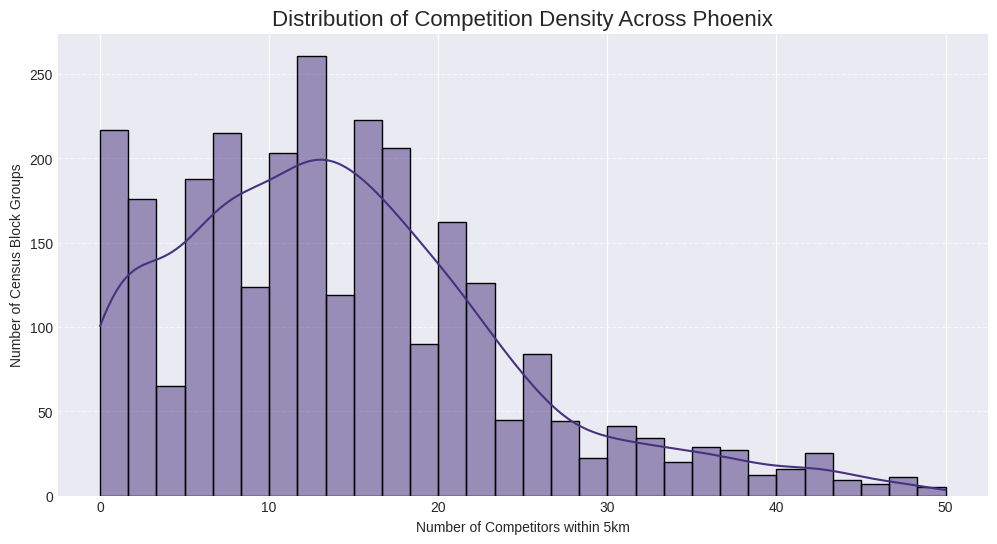

In [8]:
# --- 6. ENGINEER FEATURE: COMPETITION DENSITY ---
# We'll calculate the number of competitors within a 5km radius of each
# block group's center using a fast and accurate spatial join.

# --- 1. Define a Projected CRS for Accurate Distance Calculation ---
# UTM Zone 12N is appropriate for Phoenix, AZ, and its units are in meters.
PROJ_CRS = "EPSG:32612"

# --- 2. Re-project DataFrames to the Meter-Based CRS ---
# Use the consistent variable names from our refined workflow.
phoenix_census_proj = phoenix_census_gdf.to_crs(PROJ_CRS)
facilities_proj = facilities_gdf.to_crs(PROJ_CRS)

# --- 3. Create 5km Buffers Around Block Group Centers ---
# Buffering the centroid is more precise than buffering the entire polygon.
# Radius is in meters (5km = 5000m).
buffers_gdf = gpd.GeoDataFrame(
    geometry=phoenix_census_proj.geometry.centroid.buffer(5000),
    crs=PROJ_CRS
)
# We need to carry the GEOID over for the final merge
buffers_gdf['GEOID'] = phoenix_census_proj['GEOID'].values

# --- 4. Perform Spatial Join to Find Competitors in Buffers ---
# This efficiently counts all facility points that fall 'within' each buffer circle.
join_gdf = gpd.sjoin(facilities_proj, buffers_gdf, how="inner", predicate="within")

# --- 5. Count Competitors and Merge Results ---
# Group by the block group's GEOID and count how many facilities were found.
competition_counts = join_gdf.groupby('GEOID').size()

# Merge the counts back into our main DataFrame.
# We use .map() for a clean merge and fill areas with no competition with 0.
phoenix_census_gdf['competition_density'] = phoenix_census_gdf['GEOID'].map(competition_counts).fillna(0).astype(int)


# --- Feature Engineering Report ---
print("--- Competition Density Report ---")
print("Successfully calculated competition density.")
print("\n--- Data Preview with New Feature ---")
display(phoenix_census_gdf[['GEOID', 'competition_density', 'geometry']].head())

# --- Visualize the New Feature's Distribution ---
plt.figure(figsize=(12, 6))
sns.histplot(phoenix_census_gdf['competition_density'], bins=30, kde=True)
plt.title('Distribution of Competition Density Across Phoenix', fontsize=16)
plt.xlabel('Number of Competitors within 5km')
plt.ylabel('Number of Census Block Groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
# --- 7. FETCH & INTEGRATE DEMOGRAPHIC DATA (Final Version) ---

# --- 1. Define All Required Demographic Variables ---
# This dictionary maps our desired, readable names to the official Census API codes.
DEMOGRAPHIC_VARIABLES = {
    'total_population': 'B01003_001E',
    'median_income': 'B19013_001E',
    'total_housing_units': 'B25001_001E',
    'owner_occupied_units': 'B25003_002E',
    'renter_occupied_units': 'B25003_003E',
    'vacant_units': 'B25002_003E',
    'median_home_value': 'B25077_001E',
    # New variables added for deeper analysis
    'avg_household_size': 'B25014_001E',
    'median_num_rooms': 'B25017_001E',
}

# --- 2. Construct and Execute the API Call ---
variable_codes = ",".join(DEMOGRAPHIC_VARIABLES.values())
api_url = (
    f"https://api.census.gov/data/2023/acs/acs5?get={variable_codes},NAME"
    f"&for=block group:*&in=state:{STATE_FIPS}&in=county:{COUNTY_FIPS}"
    f"&key={CENSUS_API_KEY}"
)

try:
    response = requests.get(api_url)
    response.raise_for_status()  # This will raise an error for bad responses (4xx or 5xx)
    data = response.json()

    # --- 3. Process the API Response into a Clean DataFrame ---
    census_df = pd.DataFrame(data[1:], columns=data[0])

    # Create the GEOID for merging
    census_df['GEOID'] = census_df['state'] + census_df['county'] + census_df['tract'] + census_df['block group']

    # Convert all variable columns to numeric, coercing errors
    for code in DEMOGRAPHIC_VARIABLES.values():
        census_df[code] = pd.to_numeric(census_df[code], errors='coerce')

    # IMPORTANT: Replace the Census API's special null codes with np.nan
    census_df.replace([-666666666, -888888888, -999999999], np.nan, inplace=True)

    # Rename the cryptic columns to our human-readable names
    rename_map = {v: k for k, v in DEMOGRAPHIC_VARIABLES.items()}
    census_df.rename(columns=rename_map, inplace=True)

    # --- 4. Merge Demographic Data into Our Main GeoDataFrame ---
    # Ensure merge keys are the same type (string is safest)
    phoenix_census_gdf['GEOID'] = phoenix_census_gdf['GEOID'].astype(str)
    census_df['GEOID'] = census_df['GEOID'].astype(str)

    # This creates our final, master DataFrame for the rest of the analysis.
    final_gdf = phoenix_census_gdf.merge(
        census_df, on='GEOID', how='left'
    )

    print("✅ Successfully fetched all demographic data, including new variables.")
    # Display a sample of the new raw data columns
    display(final_gdf[['GEOID', 'avg_household_size', 'median_num_rooms']].head())

except Exception as e:
    print(f"An error occurred: {e}")

✅ Successfully fetched all demographic data, including new variables.


,GEOID,avg_household_size,median_num_rooms
0,040131059001,575,653
1,040131057011,588,595
2,040131057021,722,746
3,040131058001,492,511
4,040131093002,526,526


In [10]:
# --- 7a. FETCH TRACT-LEVEL SUPPLEMENTAL DATA ---
# This data is not available at the block group level, so we fetch it for
# census tracts and then join it back to our block group data.

print("Fetching supplemental data at the Census Tract level...")

# --- 1. Define Tract-Level Variables ---
TRACT_LEVEL_VARIABLES = {
    # Vehicle Ownership
    'total_households': 'B08201_001E',
    'households_2_vehicles': 'B08201_004E',
    'households_3_vehicles': 'B08201_005E',
    'households_4plus_vehicles': 'B08201_006E',
    'total_pop_by_birth': 'B05002_001E',
    'born_in_different_state': 'B05002_003E'
}

# --- 2. Construct and Execute API Call for TRACTS ---
variable_codes = ",".join(TRACT_LEVEL_VARIABLES.values())
api_url_tract = (
    f"https://api.census.gov/data/2023/acs/acs5?get={variable_codes}"
    f"&for=tract:*&in=state:{STATE_FIPS}&in=county:{COUNTY_FIPS}"
    f"&key={CENSUS_API_KEY}"
)

try:
    response = requests.get(api_url_tract)
    response.raise_for_status()
    data = response.json()

    # --- 3. Process into a Clean DataFrame ---
    supplemental_df_tract = pd.DataFrame(data[1:], columns=data[0])

    supplemental_df_tract['TRACT_GEOID'] = supplemental_df_tract['state'] + supplemental_df_tract['county'] + supplemental_df_tract['tract']

    for code in TRACT_LEVEL_VARIABLES.values():
        supplemental_df_tract[code] = pd.to_numeric(supplemental_df_tract[code], errors='coerce')

    rename_map = {v: k for k, v in TRACT_LEVEL_VARIABLES.items()}
    supplemental_df_tract.rename(columns=rename_map, inplace=True)

    supplemental_df_tract = supplemental_df_tract[['TRACT_GEOID'] + list(TRACT_LEVEL_VARIABLES.keys())]

    # --- 4. Merge Tract Data back into our Block Group DataFrame ---
    final_gdf['TRACT_GEOID'] = final_gdf['GEOID'].str[:11]
    final_gdf = final_gdf.merge(supplemental_df_tract, on='TRACT_GEOID', how='left')

    # --- 5. Clean Up ---
    # Drop the temporary merge key column to keep the DataFrame tidy.
    final_gdf.drop(columns=['TRACT_GEOID'], inplace=True)

    print("Successfully fetched and merged all tract-level supplemental data.")
    display(final_gdf[['GEOID', 'total_households', 'born_in_different_state']].head())

except Exception as e:
    print(f"An error occurred: {e}")

Fetching supplemental data at the Census Tract level...
Successfully fetched and merged all tract-level supplemental data.


,GEOID,total_households,born_in_different_state
0,040131059001,2035,2453
1,040131057011,1216,1871
2,040131057021,1315,1800
3,040131058001,2189,2806
4,040131093002,1137,2479


In [11]:
# --- ADDENDUM: SOURCING POINTS OF INTEREST (POIs) ---
import osmnx as ox

print("Querying OpenStreetMap for Points of Interest...")

# --- 1. Define our search boundary ---
# We use the total boundary of our phoenix_census_gdf as the search area.
search_area = phoenix_census_gdf.unary_union

# --- 2. Define the OSM "tags" for the features we want ---
# These are key-value pairs that identify specific types of places in OSM.
tags = {
    "apartments": {"building": "apartments"},
    "universities": {"amenity": ["university", "college"]},
    "military": {"landuse": "military"}
}

# --- 3. Fetch the data for each tag ---
poi_gdfs = {}
for poi_name, poi_tags in tags.items():
    try:
        print(f"   -> Searching for '{poi_name}'...")
        gdf = ox.features_from_polygon(search_area, poi_tags)
        poi_gdfs[poi_name] = gdf
        print(f"Found {len(gdf)} features for '{poi_name}'.")
    except Exception as e:
        print(f"Could not find any features for '{poi_name}'.")
        poi_gdfs[poi_name] = None

# --- 4. Report and Preview ---
print("\n--- POI Data Report ---")
apartments_gdf = poi_gdfs.get("apartments")
if apartments_gdf is not None:
    print("Preview of Apartment Data:")
    display(apartments_gdf[['geometry', 'name']].head())
else:
    print("No apartment data was found.")

Querying OpenStreetMap for Points of Interest...
   -> Searching for 'apartments'...
Found 20417 features for 'apartments'.
   -> Searching for 'universities'...
Found 96 features for 'universities'.
   -> Searching for 'military'...
Found 47 features for 'military'.

--- POI Data Report ---
Preview of Apartment Data:


geometry                   name
element id                                                            
node    359254896    POINT (-111.94767 33.4252)  West Fifth Apartments
        2334894668  POINT (-112.25662 33.53194)         Quarter Condos
        2686028216  POINT (-112.25663 33.53398)                    NaN
        2691199130  POINT (-112.08444 33.38944)                    NaN
        2691199132   POINT (-112.08413 33.3881)                    NaN

In [12]:
# --- ADDENDUM: ENGINEERING PROXIMITY & COUNT FEATURES ---
import geopandas as gpd

print("Engineering new features from POI data...")

# --- 1. Re-project all data to a meter-based CRS for accurate calculations ---
# We use the PROJ_CRS = "EPSG:32612" we defined earlier.
final_gdf_proj = final_gdf.to_crs(PROJ_CRS)

# --- 2. Feature 1: Count of Apartments within each Block Group ---
apartments_gdf = poi_gdfs.get("apartments")
if apartments_gdf is not None:
    # Ensure the apartment data is in the same projection
    apartments_proj = apartments_gdf.to_crs(PROJ_CRS)

    # Spatially join apartments to block groups
    join_apartments = gpd.sjoin(final_gdf_proj, apartments_proj, how="left", predicate="contains")

    # Count the number of apartments per block group
    apartment_counts = join_apartments.groupby("GEOID").size()

    # Map the counts back to our main DataFrame
    final_gdf['apartment_count'] = final_gdf['GEOID'].map(apartment_counts).fillna(0).astype(int)
    print("    'apartment_count' feature created.")
else:
    final_gdf['apartment_count'] = 0 # If no apartments were found, create a column of zeros
    print("    No apartment data found, 'apartment_count' set to 0.")

# --- 3. Feature 2: Distance to Nearest University ---
universities_gdf = poi_gdfs.get("universities")
if universities_gdf is not None:
    universities_proj = universities_gdf.to_crs(PROJ_CRS)

    # sjoin_nearest finds the single closest university for each block group
    join_universities = gpd.sjoin_nearest(
        final_gdf_proj, universities_proj, how="left", distance_col="dist_to_university_m"
    )
    # Remove duplicate block groups, keeping only the one with the shortest distance
    join_universities = join_universities.drop_duplicates(subset="GEOID", keep="first")

    # Map the distances (in meters) back to the main DataFrame
    final_gdf['dist_to_university_m'] = final_gdf['GEOID'].map(join_universities.set_index('GEOID')['dist_to_university_m'])
    # Convert to kilometers for easier interpretation
    final_gdf['dist_to_university_km'] = (final_gdf['dist_to_university_m'] / 1000).fillna(999) # Fill NaNs with a large distance
    print("   'dist_to_university_km' feature created.")
else:
    final_gdf['dist_to_university_km'] = 999
    print("   No university data found, distance set to 999.")

# --- 4. Feature 3: Distance to Nearest Military Base ---
military_gdf = poi_gdfs.get("military")
if military_gdf is not None:
    military_proj = military_gdf.to_crs(PROJ_CRS)

    # Repeat the same 'sjoin_nearest' process for military bases
    join_military = gpd.sjoin_nearest(final_gdf_proj, military_proj, how="left", distance_col="dist_to_military_m")
    join_military = join_military.drop_duplicates(subset="GEOID", keep="first")

    final_gdf['dist_to_military_km'] = (
        final_gdf['GEOID'].map(join_military.set_index('GEOID')['dist_to_military_m']) / 1000
    ).fillna(999)
    print("   'dist_to_military_km' feature created.")
else:
    final_gdf['dist_to_military_km'] = 999
    print("    No military data found, distance set to 999.")

# --- Final Report ---
print("\n--- New Proximity & Count Feature Report ---")
new_poi_features = ['apartment_count', 'dist_to_university_km', 'dist_to_military_km']
display(final_gdf[['GEOID'] + new_poi_features].head())

Engineering new features from POI data...
    'apartment_count' feature created.
   'dist_to_university_km' feature created.
   'dist_to_military_km' feature created.

--- New Proximity & Count Feature Report ---


,GEOID,apartment_count,dist_to_university_km,dist_to_military_km
0,040131059001,8,1.782824,5.389685
1,040131057011,11,2.414399,4.253332
2,040131057021,1,1.670032,4.998472
3,040131058001,1,2.381438,4.649262
4,040131093002,1,2.629809,4.974658


In [13]:
# --- ADDENDUM: ENGINEERING THE TRAFFIC FEATURE ---

if traffic_gdf is not None:
    print("Engineering new 'traffic_count' feature...")

    # --- 1. Clean the Traffic Data ---
    traffic_column_name = 'VOLUME'
    if traffic_column_name in traffic_gdf.columns:
        traffic_gdf['traffic_count'] = pd.to_numeric(traffic_gdf[traffic_column_name], errors='coerce').fillna(0)

        # --- 2. Re-project for Accurate Distance Calculation ---
        final_gdf_proj = final_gdf.to_crs(PROJ_CRS)
        traffic_proj = traffic_gdf.to_crs(PROJ_CRS)

        # --- 3. Find the Nearest Traffic Station for Each Block Group ---
        block_group_centers = final_gdf_proj.copy()
        block_group_centers['geometry'] = block_group_centers.geometry.centroid

        join_traffic = gpd.sjoin_nearest(block_group_centers, traffic_proj, how="left")

        join_traffic = join_traffic.drop_duplicates(subset="GEOID", keep="first")

        # --- 4. Map the Traffic Count Back to Our Main DataFrame ---
        traffic_values = join_traffic.set_index('GEOID')['traffic_count']
        final_gdf['traffic_count'] = final_gdf['GEOID'].map(traffic_values).fillna(0)

        print("   'traffic_count' feature created.")

        # --- Final Report ---
        print("\n--- New Traffic Feature Report ---")
        display(final_gdf[['GEOID', 'traffic_count']].sort_values('traffic_count', ascending=False).head())

    else:
        print(f" ERROR: The traffic count column '{traffic_column_name}' was not found in the traffic data.")
        final_gdf['traffic_count'] = 0
else:
    print(" Traffic data not loaded. The 'traffic_count' feature will be a column of zeros.")
    final_gdf['traffic_count'] = 0

Engineering new 'traffic_count' feature...
   'traffic_count' feature created.

--- New Traffic Feature Report ---


,GEOID,traffic_count
1572,040131094011,30286
146,040131162051,29142
1620,040131167381,28329
154,040131163003,27812
1054,040131167382,27755


In [14]:
# --- 8. ENGINEER FINAL FEATURES ---

# --- 1. Calculate Base Metrics ---
# These are the direct calculations from our raw census data.
total_units = final_gdf['total_housing_units'].replace(0, np.nan)
final_gdf['renter_pct'] = final_gdf['renter_occupied_units'] / total_units
final_gdf['owner_pct'] = final_gdf['owner_occupied_units'] / total_units
final_gdf['vacancy_rate'] = final_gdf['vacant_units'] / total_units

multi_car_households = (final_gdf['households_2_vehicles'] + final_gdf['households_3_vehicles'] + final_gdf['households_4plus_vehicles'])
total_households = final_gdf['total_households'].replace(0, np.nan)
final_gdf['multi_car_hh_pct'] = multi_car_households / total_households

total_pop_birth = final_gdf['total_pop_by_birth'].replace(0, np.nan)
final_gdf['pct_migrant'] = final_gdf['born_in_different_state'] / total_pop_birth

# --- 2. Calculate Winning Interaction Features ---
final_gdf['income_x_renter'] = final_gdf['median_income'] * final_gdf['renter_pct']
final_gdf['migrant_x_multicar'] = final_gdf['pct_migrant'] * final_gdf['multi_car_hh_pct']
final_gdf['density_x_vacancy'] = final_gdf['total_population'] * final_gdf['vacancy_rate']

# --- 3. Handle Potential Missing Values in All Engineered Features ---
# We'll fill any NaNs that resulted from division with 0.
engineered_feature_cols = [
    'renter_pct', 'owner_pct', 'vacancy_rate', 'multi_car_hh_pct', 'pct_migrant',
    'income_x_renter', 'migrant_x_multicar', 'density_x_vacancy'
]
final_gdf[engineered_feature_cols] = final_gdf[engineered_feature_cols].fillna(0)

# --- Feature Engineering Report ---
print("--- Final Feature Report ---")
print(" Successfully engineered all final base and interaction features.")
print("\n--- Data Preview with a Sample of New Features ---")
display(final_gdf[['GEOID', 'renter_pct', 'multi_car_hh_pct', 'income_x_renter']].head())

--- Final Feature Report ---
 Successfully engineered all final base and interaction features.

--- Data Preview with a Sample of New Features ---


,GEOID,renter_pct,multi_car_hh_pct,income_x_renter
0,040131059001,0.130168,0.496314,14119.372129
1,040131057011,0.455462,0.585526,28767.902521
2,040131057021,0.163539,0.653232,15331.769437
3,040131058001,0.424658,0.730014,45335.589041
4,040131093002,0.262357,0.824978,16943.828897


In [15]:
# --- 9. PREPARE DATA FOR MACHINE LEARNING (Final Version) ---

# --- 1. Define Final Features (X) and Target (y) ---
TARGET_VARIABLE = 'competition_density'

# This list now contains all our best raw, engineered, interaction, and POI features.
FEATURE_VARIABLES = [
    # Raw Demographic Features
    'median_income',
    'median_home_value',
    'total_population',
    'avg_household_size',
    'median_num_rooms',
    # Engineered Demographic Features
    'renter_pct',
    'owner_pct',
    'vacancy_rate',
    'multi_car_hh_pct',
    'pct_migrant',
    # Interaction Features
    'income_x_renter',
    'migrant_x_multicar',
    'density_x_vacancy',
    # NEW: POI-based Features
    'apartment_count',
    'dist_to_university_km',
    'dist_to_military_km',
    'traffic_count'
]

# --- 2. Create a Clean Model DataFrame & Handle Missing Values ---
model_gdf = final_gdf.copy()
model_gdf.dropna(subset=[TARGET_VARIABLE], inplace=True)
model_gdf[FEATURE_VARIABLES] = model_gdf[FEATURE_VARIABLES].fillna(model_gdf[FEATURE_VARIABLES].median())

# --- 3. Split Data into Training and Testing Sets ---
X = model_gdf[FEATURE_VARIABLES]
y = model_gdf[TARGET_VARIABLE]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# --- 4. Scale Numerical Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Data Preparation Report ---
print("--- Machine Learning Data Prep Report ---")
print(" Target variable:", TARGET_VARIABLE)
print(f" {len(FEATURE_VARIABLES)} features selected for modeling (including POIs).")
print(" Missing values handled and features scaled.")
print("\nData has been split into training and testing sets:")
print(f"   Training features shape: {X_train_scaled.shape}")
print(f"   Testing features shape:  {X_test_scaled.shape}")

--- Machine Learning Data Prep Report ---
 Target variable: competition_density
 17 features selected for modeling (including POIs).
 Missing values handled and features scaled.

Data has been split into training and testing sets:
   Training features shape: (2244, 17)
   Testing features shape:  (562, 17)


 Training the Random Forest model...
 Model training complete.

--- Model Performance Report ---
R-squared (R²): 0.714
  -> This means our model can explain about 71.4% of the variation in competition density.

Mean Absolute Error (MAE): 4.170
  -> This means, on average, our model's prediction is off by about 4.17 facilities.

Out-of-Bag (OOB) Score: 0.666
  -> A reliable internal score, similar to R², that confirms the model's consistency.


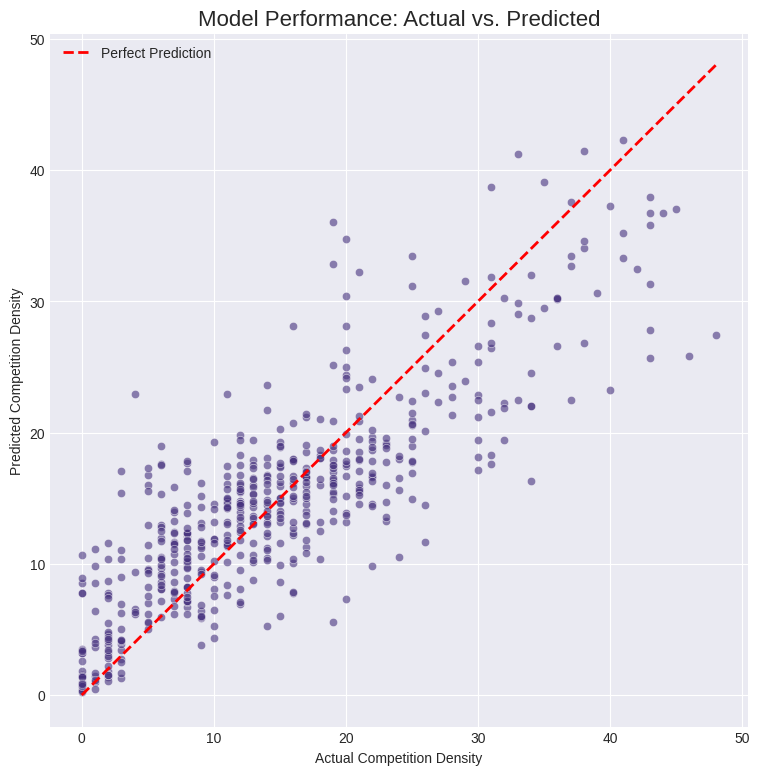

In [16]:
# --- 10. TRAIN & EVALUATE MACHINE LEARNING MODEL ---
# With our data prepared, we can now train our Random Forest model and
# evaluate its performance on the unseen test data.

# --- 1. Initialize and Train the Model ---
# We use RandomForestRegressor, a powerful and reliable model for this type of problem.
rf_model = RandomForestRegressor(n_estimators=100, random_state=SEED, oob_score=True)

print(" Training the Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print(" Model training complete.")

# --- 2. Make Predictions on the Test Set ---
# The model has never seen this data, so this is a true test of its performance.
y_pred = rf_model.predict(X_test_scaled)

# --- 3. Evaluate Model Performance ---
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
oob = rf_model.oob_score_

print("\n--- Model Performance Report ---")
print(f"R-squared (R²): {r2:.3f}")
print(f"  -> This means our model can explain about {r2:.1%} of the variation in competition density.")
print(f"\nMean Absolute Error (MAE): {mae:.3f}")
print(f"  -> This means, on average, our model's prediction is off by about {mae:.2f} facilities.")
print(f"\nOut-of-Bag (OOB) Score: {oob:.3f}")
print(f"  -> A reliable internal score, similar to R², that confirms the model's consistency.")

# --- 4. Visualize Actual vs. Predicted Values ---
plt.figure(figsize=(9, 9))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
# A perfect prediction would lie on the red dashed line.
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Model Performance: Actual vs. Predicted', fontsize=16)
plt.xlabel('Actual Competition Density')
plt.ylabel('Predicted Competition Density')
plt.legend()
plt.grid(True)
plt.show()

--- Top 10 Untapped Market Opportunities ---
These are locations where the demographic demand signal is much stronger
than the current level of competition.


,GEOID,opportunity_score,predicted_competition,competition_density
986,040131167331,18.96,22.96,4
2669,040132182002,17.02,36.02,19
252,040133185011,14.77,34.77,20
433,040130610311,14.05,17.05,3
511,040130924013,13.86,32.86,19
930,040131067032,12.95,18.95,6
1602,040136124011,12.38,15.38,3
2138,040130927192,12.33,17.33,5
2436,040134226172,12.11,28.11,16
1662,040134202063,11.92,22.92,11


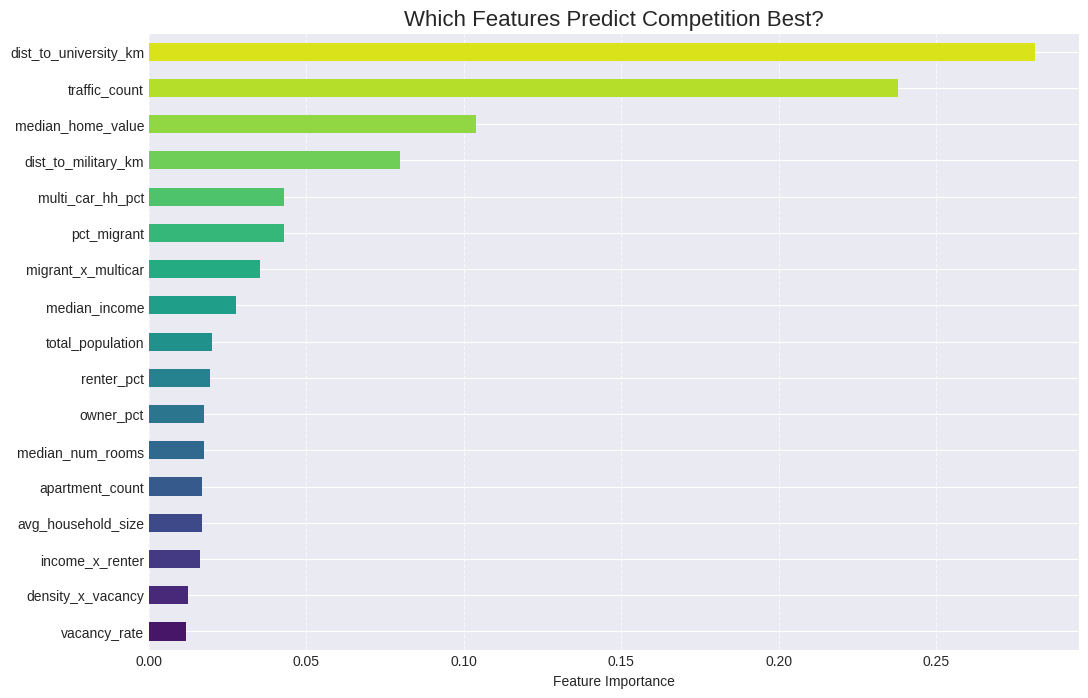

In [17]:
# --- 11. GENERATE INSIGHTS & FIND OPPORTUNITIES ---
# We'll use our trained model to predict the expected competition level for every
# block group. The best opportunities are where the predicted competition is high,
# but the actual competition is low.

# --- 1. Make Predictions on the ENTIRE Dataset ---
# First, prepare the full dataset just like we prepared the training data.
full_data_features = final_gdf[FEATURE_VARIABLES].fillna(final_gdf[FEATURE_VARIABLES].median())

# IMPORTANT: We use the SAME scaler that was fitted on the training data.
full_data_scaled = scaler.transform(full_data_features)

# Now, predict the "expected" competition density for every block group.
final_gdf['predicted_competition'] = rf_model.predict(full_data_scaled)

# --- 2. Calculate the "Opportunity Score" ---
# This score is the gap between the predicted potential and the current reality.
# A higher score indicates a more attractive, untapped market.
final_gdf['opportunity_score'] = final_gdf['predicted_competition'] - final_gdf[TARGET_VARIABLE]

# --- 3. Generate Final Rankings ---
# Sort the DataFrame to find the locations with the highest opportunity score.
top_opportunities = final_gdf.sort_values(by='opportunity_score', ascending=False)

# --- Final Recommendations Report ---
print("--- Top 10 Untapped Market Opportunities ---")
print("These are locations where the demographic demand signal is much stronger")
print("than the current level of competition.")

display_cols = [
    'GEOID',
    'opportunity_score',
    'predicted_competition',
    TARGET_VARIABLE
]
display(top_opportunities[display_cols].head(10).style.format('{:.2f}', subset=['opportunity_score', 'predicted_competition']))

# --- 4. Understand a key driver - Feature Importance ---
# This plot shows which demographic features the model found most important.
importances = pd.Series(rf_model.feature_importances_, index=FEATURE_VARIABLES).sort_values(ascending=True)

plt.figure(figsize=(12, 8))
importances.plot(kind='barh', color=sns.color_palette('viridis', len(importances)))
plt.title('Which Features Predict Competition Best?', fontsize=16)
plt.xlabel('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# --- FINAL STEP: APPLYING REALITY CHECK FILTERS (ZONING & LAND USE) ---

if 'zoning_gdf' in locals() and 'land_use_gdf' in locals() and zoning_gdf is not None and land_use_gdf is not None:
    print("Applying zoning and land use data as final filters...")

    top_opportunities_geo = gpd.GeoDataFrame(top_opportunities, geometry='geometry', crs=final_gdf.crs)

    # --- 1. First Filter: Zoning ---
    zoning_gdf_proj = zoning_gdf.to_crs(top_opportunities_geo.crs)
    viable_zones = ['C-2', 'C-3', 'A-1', 'A-2', 'IND-A']
    viable_zoning_areas = zoning_gdf_proj[zoning_gdf_proj['ZONING'].isin(viable_zones)]
    zoned_recommendations = gpd.sjoin(
        top_opportunities_geo, viable_zoning_areas, how="inner", predicate="intersects"
    ).drop_duplicates(subset='GEOID')
    print(f"   -> Found {len(zoned_recommendations)} opportunities in viable zones.")

    # --- 2. Second Filter: Land Use (Remove ALL Parks) ---
    print("\n Applying Land Use data to remove all park locations...")

    # Unify CRS for the land use join
    land_use_proj = land_use_gdf.to_crs(zoned_recommendations.crs)

    # Use the list of codes that represent parks or open space
    park_codes_to_exclude = [70, 71]
    park_land_use = land_use_proj[land_use_proj['NEWCODE'].isin(park_codes_to_exclude)]

    # Perform an 'anti-join' by finding which recommendations intersect with parks...
    join_parks = gpd.sjoin(zoned_recommendations, park_land_use, how="left", predicate="intersects", lsuffix='rec', rsuffix='park')

    # ...and then keeping only the ones that DID NOT get a match.
    final_recommendations = join_parks[join_parks['index_park'].isnull()].copy()

    print(f"   -> {len(zoned_recommendations) - len(final_recommendations)} park locations were removed.")

    # --- 3. Final Report ---
    final_recommendations = final_recommendations.sort_values(by='opportunity_score', ascending=False)
    final_recommendations.rename(columns={'GEOID_rec': 'GEOID', 'ZONING_rec': 'ZONING'}, inplace=True, errors='ignore')

    print("\n---  Final, Actionable Recommendations (Post-All-Filters) ---")
    print(f"Found {len(final_recommendations)} top opportunities in buildable, non-park zones.")

    display_cols = ['GEOID', 'opportunity_score', 'traffic_count', 'ZONING']
    display(final_recommendations[display_cols].head(10))

else:
    print("Zoning or Land Use data not loaded. Skipping final filters.")

Applying zoning and land use data as final filters...
   -> Found 836 opportunities in viable zones.

 Applying Land Use data to remove all park locations...
   -> 608 park locations were removed.

---  Final, Actionable Recommendations (Post-All-Filters) ---
Found 228 top opportunities in buildable, non-park zones.


,GEOID,opportunity_score,traffic_count,ZONING
2138,040130927192,12.33,568,C-2
2137,040130927191,10.97,568,C-2
1835,040130820121,9.85,6044,C-2
387,040131140002,9.61,10525,A-1
2381,040136118004,9.61,15585,C-2
2380,040136118002,8.40,916,C-2
1849,040131042262,7.98,863,C-2
1068,040131160004,7.15,3414,C-2
1889,040131112041,6.18,16942,C-3
1362,040136152022,5.82,6774,C-2


In [19]:
# --- 12. VISUALIZE FINAL RECOMMENDATIONS (Corrected) ---

# --- 1. Prepare Data for Plotting ---
final_recommendations_geo = gpd.GeoDataFrame(
    final_recommendations, geometry='geometry', crs=final_gdf.crs
)

# --- 2. Center the Map on Phoenix ---
phoenix_center_point = final_gdf.unary_union.centroid
center_lat = phoenix_center_point.y
center_lng = phoenix_center_point.x

# --- 3. Initialize the Interactive Map ---
m = folium.Map(location=[center_lat, center_lng], zoom_start=10, tiles="cartodbpositron")

# --- 4. Add Map Layers ---

# Layer 1: Existing Facilities (off by default)
fg_existing = folium.FeatureGroup(name="Existing Facilities (Blue Dots)", show=False)
for _, row in facilities_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x], radius=3,
        color="navy", fill=True, fill_opacity=0.7,
        popup=f"Facility: {row.get('name', 'N/A')}"
    ).add_to(fg_existing)
fg_existing.add_to(m)

# Layer 2: Top 10 Opportunity Zones (Highlighted Polygons)
fg_shapes = folium.FeatureGroup(name="Top 10 Opportunity Zones (Highlighted)")
style_function = lambda x: {'fillColor': '#228B22', 'color': 'black', 'weight': 1, 'fillOpacity': 0.4}

# This removes any problematic data types like Timestamps.
geojson_data = final_recommendations_geo.head(10)[['geometry', 'GEOID', 'opportunity_score']]

folium.GeoJson(
    geojson_data,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['GEOID', 'opportunity_score'], aliases=['GEOID:', 'Opportunity Score:'])
).add_to(fg_shapes)
fg_shapes.add_to(m)

# Layer 3: Top 10 Opportunity Markers (Red Stars)
fg_markers = folium.FeatureGroup(name="Top 10 Opportunity Markers (Red Stars)")
for _, row in final_recommendations_geo.head(10).iterrows():
    if row.geometry and not row.geometry.is_empty:
        folium.Marker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            icon=folium.Icon(color="red", icon="star"),
            popup=(f"<b>GEOID:</b> {row['GEOID']}<br><br>"
                   f"<b>Actual Competition:</b> {int(row[TARGET_VARIABLE])}<br>"
                   f"<b>Predicted Competition:</b> {row['predicted_competition']:.2f}<br>"
                   f"<b>Opportunity Score:</b> {row['opportunity_score']:.2f}")
        ).add_to(fg_markers)
fg_markers.add_to(m)

# --- 5. Add Layer Control and Display ---
folium.LayerControl().add_to(m)

print("✅ Final interactive map created showing fully filtered recommendations.")
m

✅ Final interactive map created showing fully filtered recommendations.
